# tf.data 모듈
- 데이터 입력 파이프라인을 위한 모듈
    - 모델 학습/평가를 위한 대용량 데이터셋을 제공(feeding)하기 위한 모듈
    - raw dataset 에서 입력을 위한 **전처리**, **배치 크키**, **shuffling**등을 한번에 처리 가능케 함
- tf.data.Dataset 추상클래스에서 상속된 여러가지 클래스들을 제공
    - 입력 소스의 제공 형태에 따라 다양한 방식을 제공

## Dataset API 사용
1. **Dataset 생성**
    - raw dataset을 지정 (Loading)
    - from_tensor_slices(), from_generator() 클래스 메소드, tf.data.TFRecordDataset 클래스 등을 사용해 메모리나 파일에 있는 데이터를 Dataset으로 생성
    - **from_tensor_slices()**: 메모리의 리스트, 넘파이배열, 텐서플로 자료형에서 데이터를 생성

2. **제공 데이터 전처리**
    - **map(함수)**: 하나 하나의 데이터를 변환
        - 함수: 값을 변환할 함수로 입력데이터셋의 개수만큼 매개변수 선언
    - **filter(함수)**: 특정 조건의 데이터만 제공하도록 처리
        - 함수: 제공할 값의 조건을 정의한 함수로 입력데이터셋의 개수만큼 매개변수 선언하고 bool 값 반환

3. **데이터 제공 설정 관련**
    - **batch(size)**: 학습/평가시 한번에 제공할 batch size 지정
        - size: int. batch size 지정
        - drop_remainder: bool. True일 경우 마지막 제공시 남은 데이터수가 batch size보다 작으면 미 제공하지
    - **shuffle(buffer 크기)**: dataset의 원소들의 순서를 혼합
        - buffer 크기: int. buffer 크기는 섞는 공간의 크기로  **데이터보다 크거나 같으면** 완전셔플, **적으면 일부만 가져와서 섞어** 완전셔플 불가
        - 데이터 사이즈가 너무 커서 메모리가 부족할 경우 버퍼크기를 적게 함
        - 메모리가 충분하다면 데이터의 개수와 동일하게 함
    - **repeat(count)**: 전체 데이터를 한번 다 제공한 뒤 다시 데이터를 제공
        - count: 몇번 제공할지 반복 횟수
        - shuffle이 적용된 Dataset의 경우 다음 반복 제공마다 shuffle을 진행 (에폭단위)
        

- 각 tf.data 함수들은 각 기능에 맞게 데이터를 처리하는 Dataset 객체를 반환

### Dataset 메소드
- take(개수): 지정한 개수만큼의 데이터만 제공

In [1]:
import tensorflow as tf
import numpy as np

##### Tensor
- TensorFlow의 기본 data type
- numpy가 ndarray를 이용해 데이터를 관리하듯이 tensorflow를 Tensor를 이용해 데이터를 관리
    - Tensorflow의 모델 학습/평가 시 사용하는 데이터셋(Train, Validation, Test)은 tf.Tensor 타입
        - 학습/평가(model.fit(), model.evaluate()) 시 ndarray를 입력 데이터셋으로 삽입 할 경우 tf.Tensor로 변형하여 처리
        - tf.Tensor는 데이터 셋을 ndarray로 가지고 있음

In [2]:
t = tf.constant([1,2,3], dtype="float32")
t

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [3]:
# tensor=>numpy 변환
a = t.numpy()
a

array([1., 2., 3.], dtype=float32)

In [4]:
# numpy/list => tensor 변환
t2 = tf.constant(a)
t2

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [5]:
# numpy/list => tensor 변환
t3 = tf.convert_to_tensor(a)
t3

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

## Dataset 예제

In [6]:
raw_data1 = np.arange(10)
raw_data1 # ndarray -> 메모리

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
# 메모리의 ndarray(Tensor)들을 읽는 Dataset 생성 -> Dataset.from_tensor_slices(변수) 클래스 메소드 사용
dataset = tf.data.Dataset.from_tensor_slices(raw_data1)
print(type(dataset)) # Dataset은 생성 시 데이터를 읽거나 처리하지 않음 -> 데이터셋을 사용하는 시점(모델학습, 평가)에 읽음 -> Lazy 실행

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


In [8]:
# Dataset들은 iterable 타임 (for in 사용 가능)
for data in dataset:
    print(data) # for in 문 Dataset이 가지고 있는 원소들을 하나씩(batch size) 제공

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


##### x, y 묶어서 제공
- 두개 이상의 데이터셋을 묶어서 제공할 경우 Tuple로 묶어 반환
    - Dataset이 feeding 할 때는 같은 index의 값들을 tuple로 묶어서 제공 (zip()과 동일)

In [9]:
raw_data2 = np.arange(10,20)
raw_data2

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [10]:
print(raw_data1)
print(raw_data2)

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]


In [11]:
dataset2 = tf.data.Dataset.from_tensor_slices((raw_data1, raw_data2)) 
# for i in dataset2:
#    print(i) # tuple(raw_data1 원소, raw_data2 원소) 같은 것들을 튜플로 묶어 반환
#    break
for X, y in dataset2: # tuple대입
    print(X, y, sep=' | ')

tf.Tensor(0, shape=(), dtype=int32) | tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32) | tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32) | tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32) | tf.Tensor(13, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32) | tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32) | tf.Tensor(15, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32) | tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32) | tf.Tensor(17, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32) | tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32) | tf.Tensor(19, shape=(), dtype=int32)


In [12]:
dataset3 = dataset.take(3) # take(n) : 지정한 개수(n) 만큼 조회 -> Dataset 값 조회 시 사용
# plpeline : TensorSliceDataset(dataset) --- TakeDataset(dataset3) 
#    dataset3이용 값 조회 -> dataset이 데이터 읽음 -> dataset3이 값을 3개까지 제공하는 기능 제공
print(type(dataset3))
for data in dataset3:
    print(data)

<class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)


##### shuffle

In [13]:
dataset4 = dataset.shuffle(10) # buffer size : 10 (dataset 원소개수와 동일 => 완전 셔플)
# raw_data1 읽기 -> TensorSliceDataset(dataset) 혼합 -> ShuffleDataset(dataset4)
print(type(dataset4))
for data in dataset4:
    print(data)

<class 'tensorflow.python.data.ops.dataset_ops.ShuffleDataset'>
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)


##### batch
- drop_remainder: boolean(기본-False)
    - batch로 제공할 데이터의 개수가 설정한 batch_size 보다 적으면 미제공
    - Train dataset을 만들 때 True로 설정하여 항상 일정한 batch size로 학습할 수 있도록 함
    - drop 되는 데이터는 다른 epoch을 반복 시 사용

In [14]:
dataset5 = dataset.batch(3, drop_remainder=True) # drop_remainder=True : 배치 처리 후 남은 데이터 제거
# raw_data1 읽기 => TensorSliceDataset(dataset) 배치 처리 -> BatchDataset(dataset5)
print(type(dataset5))
for data in dataset5:
    print(data)

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
tf.Tensor([0 1 2], shape=(3,), dtype=int32)
tf.Tensor([3 4 5], shape=(3,), dtype=int32)
tf.Tensor([6 7 8], shape=(3,), dtype=int32)


In [15]:
dataset6 = dataset.shuffle(10).batch(3)
# raw_data1 읽기 -> TensorSliceDataset(dataset) 혼합 -> ShuffleDataset(suffle(10)) 배치 처리 -> BatchDataset(batch(3) : dataset6)
for d in dataset6:
    print(d)

tf.Tensor([5 0 8], shape=(3,), dtype=int32)
tf.Tensor([1 7 9], shape=(3,), dtype=int32)
tf.Tensor([3 4 2], shape=(3,), dtype=int32)
tf.Tensor([6], shape=(1,), dtype=int32)


##### repeat

In [16]:
dataset7 = dataset.repeat(3) # 반복 횟수 미설정 시 무한 제공
# raw_data1 읽기 -> TensorSliceDataset(dataset) 반복 제공 -> RepeatDataset(dataset7)
print(type(dataset7))
for data in dataset7:
    print(data)

<class 'tensorflow.python.data.ops.dataset_ops.RepeatDataset'>
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
t

In [17]:
dataset8 = dataset.shuffle(10).batch(5).repeat(3)
# raw_data1 읽기 -> TensorSliceDataset(dataset) 혼합- > ShuffleDataset(suffle(10)) 배치 처리 -> BatchDataset(batch(5)) 반복 제공 -> RepeatDataset(dataset8)
for data in dataset8:
    print(data)

tf.Tensor([8 5 3 6 0], shape=(5,), dtype=int32)
tf.Tensor([4 7 9 2 1], shape=(5,), dtype=int32)
tf.Tensor([9 0 5 7 2], shape=(5,), dtype=int32)
tf.Tensor([4 6 1 8 3], shape=(5,), dtype=int32)
tf.Tensor([4 6 8 1 5], shape=(5,), dtype=int32)
tf.Tensor([7 2 9 0 3], shape=(5,), dtype=int32)


##### map

In [18]:
def mapping_func(x):
    # dataset의 원소를 하나 받아 처리하는 함수
    # 매개변수 : 원소개수에 맞추어 변수 선언
    # 반환값 : 받은 원소를 처리한 값
    return x**2

dataset9 = dataset.map(mapping_func)
print(type(dataset9))
# raw_data1 읽기 -> TensorSliceDataset(dataset) mapping처리 -> MapDataset(dataset9)
for data in dataset9:
    print(data)

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(36, shape=(), dtype=int32)
tf.Tensor(49, shape=(), dtype=int32)
tf.Tensor(64, shape=(), dtype=int32)
tf.Tensor(81, shape=(), dtype=int32)


In [19]:
def mapping_func2(x, y):
    return x**3, y

dataset2 = tf.data.Dataset.from_tensor_slices((raw_data1, raw_data2))
dataset10 = dataset2.map(mapping_func2)

In [20]:
for data in dataset10:
    print(data)

(<tf.Tensor: shape=(), dtype=int32, numpy=0>, <tf.Tensor: shape=(), dtype=int32, numpy=10>)
(<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=11>)
(<tf.Tensor: shape=(), dtype=int32, numpy=8>, <tf.Tensor: shape=(), dtype=int32, numpy=12>)
(<tf.Tensor: shape=(), dtype=int32, numpy=27>, <tf.Tensor: shape=(), dtype=int32, numpy=13>)
(<tf.Tensor: shape=(), dtype=int32, numpy=64>, <tf.Tensor: shape=(), dtype=int32, numpy=14>)
(<tf.Tensor: shape=(), dtype=int32, numpy=125>, <tf.Tensor: shape=(), dtype=int32, numpy=15>)
(<tf.Tensor: shape=(), dtype=int32, numpy=216>, <tf.Tensor: shape=(), dtype=int32, numpy=16>)
(<tf.Tensor: shape=(), dtype=int32, numpy=343>, <tf.Tensor: shape=(), dtype=int32, numpy=17>)
(<tf.Tensor: shape=(), dtype=int32, numpy=512>, <tf.Tensor: shape=(), dtype=int32, numpy=18>)
(<tf.Tensor: shape=(), dtype=int32, numpy=729>, <tf.Tensor: shape=(), dtype=int32, numpy=19>)


In [21]:
# lambda 표현 방식 1
dataset11 = dataset.map(lambda x: x**2)
for data in dataset11:
    print(data)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(36, shape=(), dtype=int32)
tf.Tensor(49, shape=(), dtype=int32)
tf.Tensor(64, shape=(), dtype=int32)
tf.Tensor(81, shape=(), dtype=int32)


In [22]:
# lambda 표현 방식 2
dataset12 = dataset2.map(lambda x, y: (x**3, y**2))
for data in dataset12:
    print(data)

(<tf.Tensor: shape=(), dtype=int32, numpy=0>, <tf.Tensor: shape=(), dtype=int32, numpy=100>)
(<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=121>)
(<tf.Tensor: shape=(), dtype=int32, numpy=8>, <tf.Tensor: shape=(), dtype=int32, numpy=144>)
(<tf.Tensor: shape=(), dtype=int32, numpy=27>, <tf.Tensor: shape=(), dtype=int32, numpy=169>)
(<tf.Tensor: shape=(), dtype=int32, numpy=64>, <tf.Tensor: shape=(), dtype=int32, numpy=196>)
(<tf.Tensor: shape=(), dtype=int32, numpy=125>, <tf.Tensor: shape=(), dtype=int32, numpy=225>)
(<tf.Tensor: shape=(), dtype=int32, numpy=216>, <tf.Tensor: shape=(), dtype=int32, numpy=256>)
(<tf.Tensor: shape=(), dtype=int32, numpy=343>, <tf.Tensor: shape=(), dtype=int32, numpy=289>)
(<tf.Tensor: shape=(), dtype=int32, numpy=512>, <tf.Tensor: shape=(), dtype=int32, numpy=324>)
(<tf.Tensor: shape=(), dtype=int32, numpy=729>, <tf.Tensor: shape=(), dtype=int32, numpy=361>)


##### filter

In [23]:
def filter_func(x):
    # filter 함수 : 제공할 데이터의 조선 정의 이조건을 만족하는 (True) 원소들만 모아 모델에 제공(feding)
    # 매개변구  DataSet으로 부터 원소을 받을 변수
    # 반환 : bool
    return x%2 == 0 

dataset13 = dataset.filter(filter_func)
print(type(dataset13))
# raw_data1 읽기 -> TensorSliceDataset(dataset) Filltering처리 -> FilterDataset(dataset13)
for data in dataset13:
    print(data)

<class 'tensorflow.python.data.ops.dataset_ops.FilterDataset'>
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


In [24]:
# lambda 표현식
dataset14 = dataset.filter(lambda x : x > 5)
for data in dataset14:
    print(data)

tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


##### 종합

In [25]:
raw_data = np.arange(-10,11)
dataset_final = tf.data.Dataset.from_tensor_slices(raw_data)\
                               .filter(lambda x:x>=0)\
                               .map(lambda y:y+10)\
                               .shuffle(raw_data.size)\
                               .batch(3)
# raw_data(-10 ~ 10 : ndarray) 읽기 -> TensorSliceDataset(dataset) filter 처리 -> FilterDataset map 처리 -> MapDataset 혼합 -> ShuffleDataset 배치처리 -> BatchDataset(dataset_final)
for data in dataset_final:
    print(data)

tf.Tensor([17 19 18], shape=(3,), dtype=int32)
tf.Tensor([20 11 16], shape=(3,), dtype=int32)
tf.Tensor([15 13 14], shape=(3,), dtype=int32)
tf.Tensor([12 10], shape=(2,), dtype=int32)


# 문제 유형별 MLP 네트워크
- Multi Layer Perceptron
    - Fully Connected Layer로 구성된 네트워크

# Regression(회귀)

## Boston Housing Dataset
보스턴 주택가격 dataset은 다음과 같은 속성을 바탕으로 해당 타운 주택 가격의 중앙값을 예측하는 문제
- CRIM: 범죄율
- ZN: 25,000 평방피트당 주거지역 비율
- INDUS: 비소매 상업지구 비율
- CHAS: 찰스강에 인접해 있는지 여부(인접:1, 아니면:0)
- NOX: 일산화질소 농도(단위: 0.1ppm)
- RM: 주택당 방의 수
- AGE: 1940년 이전에 건설된 주택의 비율
- DIS: 5개의 보스턴 직업고용센터와의 거리(가중 평균)
- RAD: 고속도로 접근성
- TAX: 재산세율
- PTRATIO: 학생/교사 비율
- B: 흑인 비율
- LSTAT: 하위 계층 비율
<br><br>
- **Target**
    - MEDV: 타운의 주택가격 중앙값(단위: 1,000달러)

In [26]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
# layer 클래스들을 제공하는 모듈
from tensorflow.keras import layers

In [27]:
# random seed 설정
np.random.seed(0) # numpy(dataset) random seed
tf.random.set_seed(0) # Tensorflow 모델 random seed

##### 데이터 로딩

In [28]:
(train_X, train_y), (test_X, test_y) = keras.datasets.boston_housing.load_data()
print(train_X.shape, test_X.shape)
print(train_y.shape, test_y.shape)

(404, 13) (102, 13)
(404,) (102,)


In [29]:
train_X[:5]

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, 0.00000e+00, 5.38000e-01,
        6.14200e+00, 9.17000e+01, 3.97690e+00, 4.00000e+00, 3.07000e+02,
        2.10000e+01, 3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, 0.00000e+00, 4.15000e-01,
        7.61000e+00, 1.57000e+01, 6.27000e+00, 2.00000e+00, 3.48000e+02,
        1.47000e+01, 3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, 0.00000e+00, 6.31000e-01,
        4.97000e+00, 1.00000e+02, 1.33250e+00, 2.40000e+01, 6.66000e+02,
        2.02000e+01, 3.75520e+02, 3.26000e+00],
       [3.96100e-02, 0.00000e+00, 5.19000e+00, 0.00000e+00, 5.15000e-01,
        6.03700e+00, 3.45000e+01, 5.98530e+00, 5.00000e+00, 2.24000e+02,
        2.02000e+01, 3.96900e+02, 8.01000e+00],
       [3.69311e+00, 0.00000e+00, 1.81000e+01, 0.00000e+00, 7.13000e-01,
        6.37600e+00, 8.84000e+01, 2.56710e+00, 2.40000e+01, 6.66000e+02,
        2.02000e+01, 3.91430e+02, 1.46500e+01]])

In [30]:
train_y[:5]

array([15.2, 42.3, 50. , 21.1, 17.7])

##### 하이퍼 파라미터, 변수 정의

In [31]:
# 하이퍼 파라미터 : 튜닝대상(변경 될 가능성이 높은 변수) => 한 곳에 몰아서 선언하는 것이 좋음
LEARNING_RATE = 0.001 # 학습률
N_EPOCHS  = 200 # epoch 수 : train data set 학습 회수
N_BATCHS = 32 # batch size : 1 step 당 학습할 데이터 개수 (2의 거듭제곱한 값)

# 사용할 변수 선언
N_TRAIN = train_X.shape[0] # train data 개수
N_TEST = test_X.shape[0] # test data 개수

##### X, y 전처리
- MLP는 선형모델을 기반으로 하므로 Feature scaling

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(train_X)
X_test = scaler.transform(test_X)

##### Dataset 생성

In [33]:
# train set을 위한 dataset 생성
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, train_y))\
                                .shuffle(N_TRAIN)\
                                .batch(N_BATCHS, drop_remainder=True)
# from_tensor_slices((X_train, train_y)) : (X_train, y_train)을 묶어 제공
# shuffle(N_TRAIN) : shuffle -> epoch 단위로 shuffle 실행
# batch(N_BATCHS, drop_remainder=True : batch size 설정 / train set에서는 보통 drop_remainder=True로 설정 (∵ 각 step마다 동일한 데이터셋을 학습하기 위해)

# validation dataset -> 학습 중 검증데이터로 사용할 dataset (이번 경우 생략)
    
# 최종 평가 시 사용할 데이터 셋
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, test_y)).batch(N_BATCHS)
# test size의 batch_size : 전체 데이터를 묶어서 검증 하는 것이 아닌 batch_size 개수별로 검증하여 그 평균을 최종 평가 결과로 반환

##### 모델 구현
1. 모델 생성 Sequential 방식
1. 모델에 Layer를 순서대로 추가
    - Input Layer
    - Hidden Layer들 (layer의 unit 수, layer의 개수 => 튜닝 대상 => 개수가 많을수록 복잡한 모델로 overfitting 발생 가능
    - Out Layer
1. 학습을 위해 compile

In [34]:
def create_housing_model():
    
    model = keras.Sequential()
    # 1. Input Layer
    # model.add(layer.InputLayer((13,))) # Input Layer 추가 1.-> Input Layer 생성 -> Featuer shape 지정
    # Input Layer 추가 2 첫번째 Hidden Layer를 추가하며 input_shape 속성에 Feature에 shape 지덩
    
    # 2. Hidden Layer 추가
    # DenseLayer : units -unit의 개수 activation : 활성 함수
    # DenseLayer의 unit 수는 개수를 줄여나감 (관례적)
    model.add(layers.Dense(units=128, activation='relu', input_shape=(13,)))
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dense(units=32, activation='relu'))
    model.add(layers.Dense(units=16, activation='relu'))
    
    # 3. Output Layer 추가 
    # 회귀 문제에 대한 output layer - units : 추론한 결과값(정답) 개수에 맞춤 - unit=1(집값 1개), activation=None(defualt, 미지정)
    model.add(layers.Dense(units=1))
    
    return model

In [35]:
def create_housing_model2():
    # 모델에 추가할 layer들을 리스트로 묶어 Squential 생성 시 삽입
    model = keras.Sequential([
        layers.Dense(units=128, activation='relu', input_shape=(13,)),
        layers.Dense(units=64, activation='relu'),
        layers.Dense(units=32, activation='relu'),
        layers.Dense(units=16, activation='relu'),
        layers.Dense(units=1, activation='relu')        
    ])
    
    return model

In [36]:
# 모델 생성
model = create_housing_model()
# 모델 컴파일 - 모델을 학습 가능하게 함 => 모델에 optimizer와 loss 함수 추가
# 회귀 문제를 위한 모델 컴파일 -> loss : mse(mean squared error)
# optimizer= 옵티마이저 객체 - learning rate등을 설정할 경우/ 문자열 - 기본 설정을 사용할 경우('adam')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse')

weight = 입력 featuer 수 * unit 수
bias = unit 수
Layer의 parameter 수 = weight + bias

In [37]:
# 생성된 모델 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1792      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
_________________________________________________________________


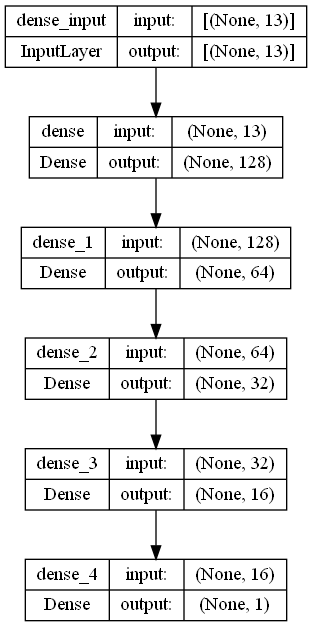

In [38]:
# graphviz를 통한 모델 구조 시각화
keras.utils.plot_model(model, show_shapes=True, to_file='housing_model.png') # show_shapes : 각 layer의 input shape와 out shape를 같이 시각화 (defaul : False)
                                                                             # to_file : 저장파일 제목 지정

##### 학습(Train)

In [39]:
# 모델.fit()  반환 -> History : 학습한 내역(epoch별 검증 결과)을 묶어 제공
hist = model.fit(train_dataset, # train dataset(tf.data - batch + shuffle) - (X, y)
                 epochs=N_EPOCHS, # epoch 수
                 validation_data=test_dataset) # validation dataset(tf.data) 제공 (X, y)
# Dataset을 이용 학습 시 경우 validation_split 사용 불가

Epoch 1/200
12/12 [==============================] - 1s 10ms/step - loss: 577.3932 - val_loss: 588.7253
Epoch 2/200
12/12 [==============================] - 0s 2ms/step - loss: 535.2090 - val_loss: 528.5541
Epoch 3/200
12/12 [==============================] - 0s 2ms/step - loss: 449.3878 - val_loss: 395.9603
Epoch 4/200
12/12 [==============================] - 0s 2ms/step - loss: 285.8776 - val_loss: 178.5870
Epoch 5/200
12/12 [==============================] - 0s 2ms/step - loss: 109.0843 - val_loss: 73.3984
Epoch 6/200
12/12 [==============================] - 0s 2ms/step - loss: 65.2827 - val_loss: 45.6336
Epoch 7/200
12/12 [==============================] - 0s 2ms/step - loss: 39.5779 - val_loss: 34.2212
Epoch 8/200
12/12 [==============================] - 0s 2ms/step - loss: 28.1576 - val_loss: 27.1693
Epoch 9/200
12/12 [==============================] - 0s 2ms/step - loss: 23.3589 - val_loss: 25.1918
Epoch 10/200
12/12 [==============================] - 0s 2ms/step - loss: 19.0858

Epoch 82/200
12/12 [==============================] - 0s 2ms/step - loss: 5.7296 - val_loss: 17.0516
Epoch 83/200
12/12 [==============================] - 0s 2ms/step - loss: 5.6737 - val_loss: 16.5297
Epoch 84/200
12/12 [==============================] - 0s 2ms/step - loss: 5.5950 - val_loss: 16.6753
Epoch 85/200
12/12 [==============================] - 0s 2ms/step - loss: 5.4228 - val_loss: 16.0829
Epoch 86/200
12/12 [==============================] - 0s 2ms/step - loss: 5.3674 - val_loss: 16.9765
Epoch 87/200
12/12 [==============================] - 0s 2ms/step - loss: 5.2871 - val_loss: 15.7956
Epoch 88/200
12/12 [==============================] - 0s 2ms/step - loss: 5.2823 - val_loss: 17.2386
Epoch 89/200
12/12 [==============================] - 0s 2ms/step - loss: 5.2796 - val_loss: 16.0001
Epoch 90/200
12/12 [==============================] - 0s 2ms/step - loss: 5.1560 - val_loss: 15.1276
Epoch 91/200
12/12 [==============================] - 0s 2ms/step - loss: 5.1404 - val_loss

12/12 [==============================] - 0s 2ms/step - loss: 2.8560 - val_loss: 12.4519
Epoch 163/200
12/12 [==============================] - 0s 2ms/step - loss: 2.8454 - val_loss: 11.8881
Epoch 164/200
12/12 [==============================] - 0s 2ms/step - loss: 2.6595 - val_loss: 11.3356
Epoch 165/200
12/12 [==============================] - 0s 2ms/step - loss: 2.5829 - val_loss: 11.1597
Epoch 166/200
12/12 [==============================] - 0s 2ms/step - loss: 2.6356 - val_loss: 11.4793
Epoch 167/200
12/12 [==============================] - 0s 2ms/step - loss: 2.5256 - val_loss: 11.7432
Epoch 168/200
12/12 [==============================] - 0s 2ms/step - loss: 2.4321 - val_loss: 11.5784
Epoch 169/200
12/12 [==============================] - 0s 2ms/step - loss: 2.4158 - val_loss: 11.9770
Epoch 170/200
12/12 [==============================] - 0s 2ms/step - loss: 2.4599 - val_loss: 11.4984
Epoch 171/200
12/12 [==============================] - 0s 2ms/step - loss: 2.3902 - val_loss: 11

##### 결과 시각화

In [40]:
import matplotlib.pyplot as plt

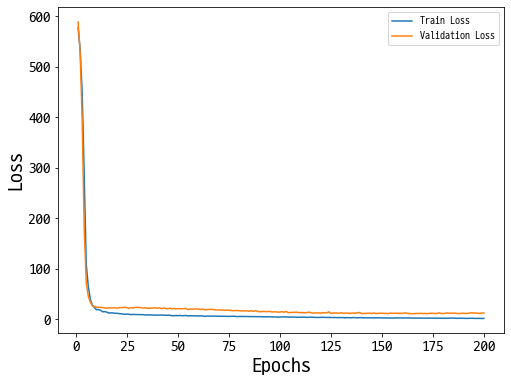

In [41]:
plt.figure(figsize=(8,6))
plt.plot(range(1,N_EPOCHS+1), hist.history['loss'], label='Train Loss')
plt.plot(range(1,N_EPOCHS+1), hist.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.show()

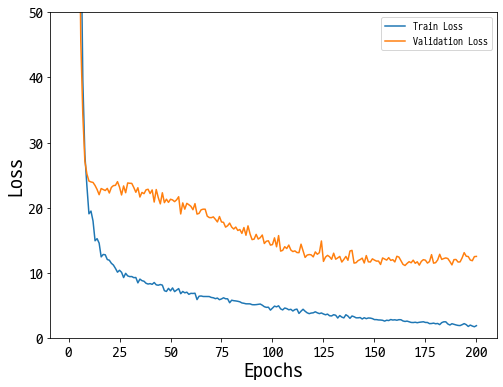

In [42]:
plt.figure(figsize=(8,6))
plt.plot(range(1,N_EPOCHS+1), hist.history['loss'], label='Train Loss')
plt.plot(range(1,N_EPOCHS+1), hist.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel('Loss')

plt.ylim(0,50) # y축 값의 범위를 제한

plt.legend()
plt.show()

##### 최종 테스트

In [43]:
loss = model.evaluate(test_dataset)
print(loss)

4/4 [==============================] - 0s 2ms/step - loss: 12.5528
12.552796363830566


##### 모델 네트워크 저장

In [44]:
model.save('models/boston_hosing_model')

INFO:tensorflow:Assets written to: models/boston_hosing_model\assets


##### 새로운 데이터 추론

In [45]:
new_data = X_test[:5]
# model.predict(추론한 Feature) : 추론결과
pred = model.predict(new_data)

1/1 [==============================] - 0s 68ms/step


In [46]:
pred

array([[ 8.571018],
       [18.152143],
       [20.61677 ],
       [32.03618 ],
       [24.65509 ]], dtype=float32)

In [47]:
test_y[:5]

array([ 7.2, 18.8, 19. , 27. , 22.2])

# 분류 (Classification)

## Fashion MNIST Dataset - 다중분류(Multi-Class Classification) 문제

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 [패션 MNIST](https://github.com/zalandoresearch/fashion-mnist) 데이터셋. 
이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 의류 품목을 나타낸다:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>그림</b> <a href="https://github.com/zalandoresearch/fashion-mnist">패션-MNIST 샘플</a> (Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

이미지는 28x28 크기이며 Gray scale이다. *레이블*(label)은 0에서 9까지의 정수 배열이다. 아래 표는 이미지에 있는 의류의 **클래스**(class)들

<table>
  <tr>
    <th>레이블</th>
    <th>클래스</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trousers</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

각 이미지는 하나의 레이블에 매핑되어 있다. 데이터셋에 클래스 이름이 들어있지 않기 때문에 나중에 이미지를 출력할 때 사용하기 위해 별도의 변수를 만들어 저장

In [48]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

np.random.seed(0)
tf.random.set_seed(0)

In [49]:
class_names = np.array(['T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

##### Data 로딩

In [50]:
(train_image, train_label), (test_image, test_label) = keras.datasets.fashion_mnist.load_data()

##### validation set  생성

In [51]:
# Train dataset => Train/Vailidation 분리
from sklearn.model_selection import train_test_split

train_image, val_image, train_label, val_label = train_test_split(train_image, train_label, test_size=0.2, stratify=train_label, random_state=0)

train_image.shape, val_image.shape, test_image.shape

((48000, 28, 28), (12000, 28, 28), (10000, 28, 28))

##### 이미지 확인

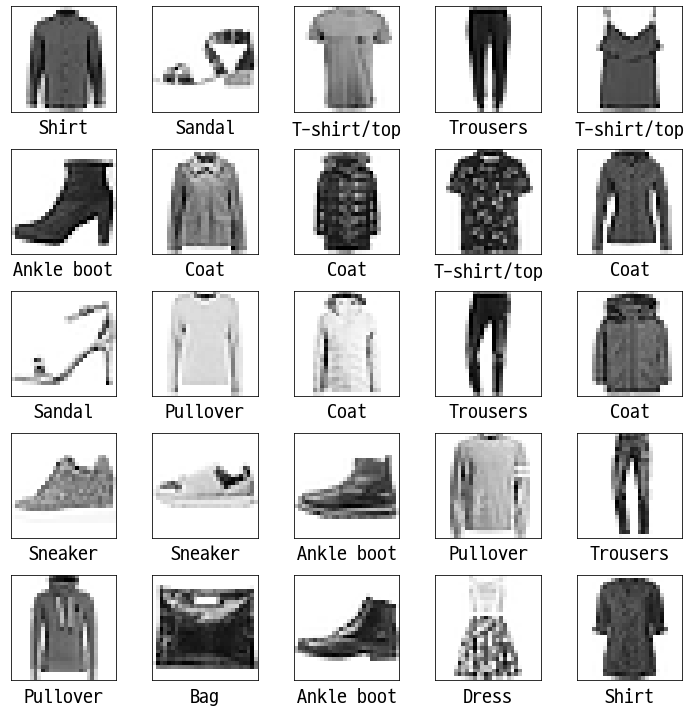

In [52]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_image[i], cmap="Greys")
    plt.xlabel(class_names[train_label[i]])

plt.tight_layout()
plt.show()

#### 하이퍼파라미터, 변수 설정

In [53]:
LEARNING_RATE = 0.001
N_EPOCHS = 20
N_BATCHS = 100

# 각 데이터 셋의 데이터 개수를 변수에 저장
N_TRAIN = train_image.shape[0]
N_VAL = val_image.shape[0]
N_TEST = test_image.shape[0]

#### X, y  전처리
- y값 처리
    - 다중 분류에서 label encoding 형식의 label을 one hot encoding 처리
    - 모델이 각 클래스별 확률을 출력하도록 구현 -> loss 계산을 위해 y(ground truth-정답)를 one hot encoding 처리

In [54]:
y_train = keras.utils.to_categorical(train_label)
y_val = keras.utils.to_categorical(val_label)
y_test = keras.utils.to_categorical(test_label)
print(y_train.shape, y_val.shape, y_test.shape)

(48000, 10) (12000, 10) (10000, 10)


- x값(이미지) 처리
    - dtype을 uint8에서 float32로 변환한다.
    - 0 ~ 1 정규화. X/255.0으로 나눈다.
    

In [55]:
X_train = train_image.astype(np.float32)
X_val = val_image.astype(np.float32)
X_test = test_image.astype(np.float32)

# 255로 나누는 작업은 dataset 생성 시 map을 이용하여 처리 예정 - 실제 활용시 map을 사용하는 것은 비효율적 -> 직접 255로 나누는 것이 효율적

##### Dataset 생성

In [56]:
# map : X, y를 받아 X는 255로 나누어 정규화 처리, y는 그대로 반환
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
                               .map(lambda x, y : (x/255, y))\
                               .shuffle(N_TRAIN)\
                               .batch(N_BATCHS, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(lambda x, y:(x/255, y)).batch(N_BATCHS)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(lambda x, y:(x/255, y)).batch(N_BATCHS)

##### 모델 생성 및 컴파일

In [57]:
def create_fashionmnist_model():
    model = keras.Sequential()
    # Hidden Layer
    # 1. Flatten + Input_shape를 지정하여 Input Layer를 추가
    # model.add(Layers.InputLayer((28, 28)))
    model.add(layers.Flatten(input_shape=(28,28)))
    # Flatten : 입력 데이터의 shape이 다차원 배열일 경우 1차원 배열러 변환 (28, 28) -> (28*28, ) => DenseLayer의 입력은 1차원배열이 되어야 함
    model.add(layers.Dense(units=256, activation='relu'))
    model.add(layers.Dense(units=128, activation='relu'))
    model.add(layers.Dense(units=64, activation='relu'))
    
    # Output Layer : 다중분류 - unit의 수 : class 수 (각 unit이 클래스별 확률 출력) => activation 함수 : soft max
    model.add(layers.Dense(units=10, activation='softmax'))
    
    return model

In [58]:
model = create_fashionmnist_model()

# 컴파일 
# 다중분류 : loss - categorical crossentropy (Log loss)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='categorical_crossentropy',
              metrics=['accuracy']) # 평가기표 accuracy 추가 (loss, accuracy 두개를 검증/최종 평가 지표로 확인)

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               200960    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________


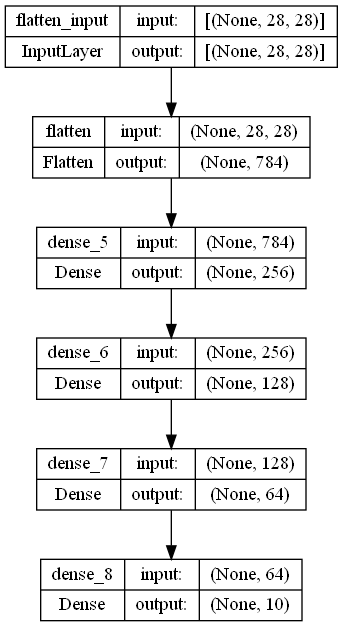

In [60]:
keras.utils.plot_model(model, show_shapes=True, to_file='fashion_mnist_model.png')

##### Train(학습)

In [61]:
hist = model.fit(train_dataset,
                 epochs=N_EPOCHS,
                 validation_data=val_dataset)

Epoch 1/20
480/480 [==============================] - 2s 3ms/step - loss: 0.5463 - accuracy: 0.8107 - val_loss: 0.4194 - val_accuracy: 0.8471
Epoch 2/20
480/480 [==============================] - 2s 3ms/step - loss: 0.3825 - accuracy: 0.8637 - val_loss: 0.3921 - val_accuracy: 0.8562
Epoch 3/20
480/480 [==============================] - 2s 3ms/step - loss: 0.3408 - accuracy: 0.8761 - val_loss: 0.3582 - val_accuracy: 0.8660
Epoch 4/20
480/480 [==============================] - 2s 3ms/step - loss: 0.3160 - accuracy: 0.8832 - val_loss: 0.3191 - val_accuracy: 0.8826
Epoch 5/20
480/480 [==============================] - 2s 3ms/step - loss: 0.2968 - accuracy: 0.8899 - val_loss: 0.3247 - val_accuracy: 0.8817
Epoch 6/20
480/480 [==============================] - 2s 3ms/step - loss: 0.2783 - accuracy: 0.8971 - val_loss: 0.3249 - val_accuracy: 0.8822
Epoch 7/20
480/480 [==============================] - 2s 3ms/step - loss: 0.2652 - accuracy: 0.9009 - val_loss: 0.3186 - val_accuracy: 0.8815
Epoch 

##### 결과 시각화
- 학습 시 epoch별 train/validation set 에 대한 검증 결과 시각화

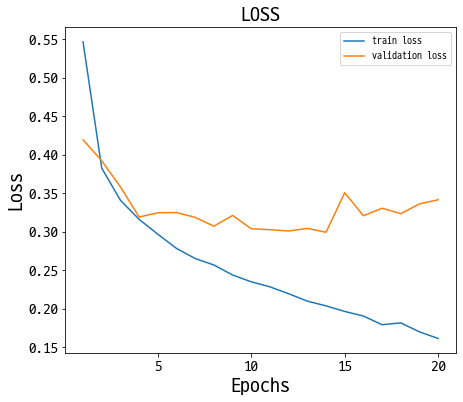

In [62]:
# loss
plt.figure(figsize=(7,6))
plt.plot(range(1, N_EPOCHS+1), hist.history['loss'], label='train loss')
plt.plot(range(1, N_EPOCHS+1), hist.history['val_loss'], label='validation loss')
plt.title("LOSS", fontsize=20)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

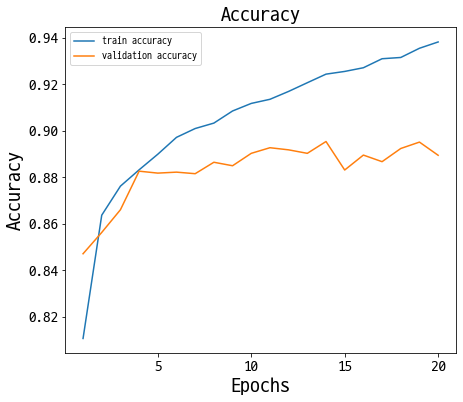

In [63]:
# accuracy
plt.figure(figsize=(7,6))
plt.plot(range(1, N_EPOCHS+1), hist.history['accuracy'], label='train accuracy')
plt.plot(range(1, N_EPOCHS+1), hist.history['val_accuracy'], label='validation accuracy')
plt.title("Accuracy", fontsize=20)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### 최종평가

In [64]:
loss, accuracy = model.evaluate(test_dataset)

100/100 [==============================] - 0s 2ms/step - loss: 0.3765 - accuracy: 0.8830


In [65]:
print(loss, accuracy)

0.3765295743942261 0.8830000162124634


####  모델저장

In [66]:
model.save('models/fashion_mnist_model')

INFO:tensorflow:Assets written to: models/fashion_mnist_model\assets


#### 모델 불러오기

In [67]:
f_model = keras.models.load_model('models/fashion_mnist_model')

#### 새로운 데이터 추론

In [68]:
new_input = X_test[:5]
new_input = new_input/255.0

In [69]:
pred = model.predict(new_input)
pred[0]

1/1 [==============================] - 0s 46ms/step


array([1.7831832e-06, 4.1221369e-08, 1.4202851e-09, 1.3960959e-06,
       7.4161954e-10, 4.2640084e-05, 9.2496126e-09, 4.2652674e-03,
       4.2428092e-09, 9.9568886e-01], dtype=float32)

In [70]:
# 예측한 label
pred_class = np.argmax(pred, axis=-1) # argmax() max값의 index
pred_class # 모델이 예측한 label

array([9, 2, 1, 1, 6], dtype=int64)

In [71]:
test_label[:5] # 정답 label

array([9, 2, 1, 1, 6], dtype=uint8)

In [72]:
pred_class_name = class_names[pred_class]
pred_class_name

array(['Ankle boot', 'Pullover', 'Trousers', 'Trousers', 'Shirt'],
      dtype='<U11')

In [73]:
pred_proba = np.max(pred, axis=-1) # 예측한 정답에 대한 확률
pred_proba

array([0.99568886, 0.9939008 , 1.        , 1.        , 0.98794425],
      dtype=float32)

In [74]:
for idx, (name, proba) in enumerate(zip(pred_class_name, pred_proba)):
    print(f"{idx}. {name}: {proba:.4f}")

0. Ankle boot: 0.9957
1. Pullover: 0.9939
2. Trousers: 1.0000
3. Trousers: 1.0000
4. Shirt: 0.9879


## 위스콘신 유방암 데이터셋 - 이진분류(Binary Classification) 문제

- **이진 분류 문제 처리 모델의 두가지 방법**
    1. positive(1)일 확률을 출력하도록 구현 (양성 여부 - O : 양성 / X : 음성) => **이번 예제**
        - output layer : unit(1), activation(sigmoid - logistic 함수)
        - loss : binary_crossentropy
    2. negative(0)일 확률과 positive(1)일 확률을 출력하도록 구현 => 다중분류 처리 방식으로 해결
        - output layer : unit(2), activation(softmax)
        - loss : categorial crossentropy
<br></br>
- 위스콘신 대학교에서 제공한 종양의 악성/양성여부 분류를 위한 데이터셋
- Feature
    - 종양에 대한 다양한 측정값들
- Target의 class
    - 0 - malignant(악성종양)
    - 1 - benign(양성종양)
    - => 양성종양 여부를 확인 하는 모델

In [75]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

np.random.seed(0)
tf.random.set_seed(0)

##### 데이터 로딩, train/validation/test set 나누기

In [76]:
X, y = load_breast_cancer(return_X_y=True)
X.shape, y.shape

((569, 30), (569,))

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=0)

X_train.shape, X_val.shape, X_test.shape

((364, 30), (91, 30), (114, 30))

In [78]:
X_train[:3]

array([[1.955e+01, 2.321e+01, 1.289e+02, 1.174e+03, 1.010e-01, 1.318e-01,
        1.856e-01, 1.021e-01, 1.989e-01, 5.884e-02, 6.107e-01, 2.836e+00,
        5.383e+00, 7.010e+01, 1.124e-02, 4.097e-02, 7.469e-02, 3.441e-02,
        2.768e-02, 6.240e-03, 2.082e+01, 3.044e+01, 1.420e+02, 1.313e+03,
        1.251e-01, 2.414e-01, 3.829e-01, 1.825e-01, 2.576e-01, 7.602e-02],
       [1.378e+01, 1.579e+01, 8.837e+01, 5.859e+02, 8.817e-02, 6.718e-02,
        1.055e-02, 9.937e-03, 1.405e-01, 5.848e-02, 3.563e-01, 4.833e-01,
        2.235e+00, 2.934e+01, 6.432e-03, 1.156e-02, 7.741e-03, 5.657e-03,
        1.227e-02, 2.564e-03, 1.527e+01, 1.750e+01, 9.790e+01, 7.066e+02,
        1.072e-01, 1.071e-01, 3.517e-02, 3.312e-02, 1.859e-01, 6.810e-02],
       [1.865e+01, 1.760e+01, 1.237e+02, 1.076e+03, 1.099e-01, 1.686e-01,
        1.974e-01, 1.009e-01, 1.907e-01, 6.049e-02, 6.289e-01, 6.633e-01,
        4.293e+00, 7.156e+01, 6.294e-03, 3.994e-02, 5.554e-02, 1.695e-02,
        2.428e-02, 3.535e-03, 2.282e

In [79]:
y_train[:3]

array([0, 1, 0])

#### 하이퍼파라미터, 변수 정의

In [80]:
LEARNING_RATE = 0.001
N_EPOCHS = 150
N_BATCHS = 50

N_TRAIN = X_train.shape[0]
N_VAL = X_val.shape[0]
N_TEST = X_test.shape[0]

#### 데이터 전처리
- 이진 분류
    - 출력 레이어의 unit을 1개, activation 함수를 sigmoid를 사용하는 경우(1일 확률) => y : 그대로 사용
    - 출력 레이어의 unit을 2개, activation 함수를 sofmax를 사용하는 경우(0일 확률, 1일 확률) - 다중분류와 동일하게 구현 => y : one hot encoding
- X: 테이블데이터
    - 문자열(범주형) : one hot encoding
    - 연속형(수치형) : feature scaling

In [81]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#### Dataset 생성
- validation/test dataset은 동일하게 pipeline을 구성
- train dataset : shuffle 추가, batch에는 drop_remainder=True로 설정
- map/filter 추가 시 train/validation/test 모두 동일하게 적용

In [82]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train)).shuffle(N_TRAIN).batch(N_BATCHS, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val)).batch(N_BATCHS)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test)).batch(N_BATCHS)

#### model 생성, 컴파일

In [83]:
def create_wisconsin_model():
    model = keras.Sequential()
    model.add(layers.Dense(units=32, activation='relu', input_shape=(30, )))
    model.add(layers.Dense(units=16, activation='relu'))
    model.add(layers.Dense(units=8, activation='relu'))
    
    # Output Layer - 이진 분류(양성의 확률을 출력하도록 구현)
    # unit의 수 : 1, activation : sigmoid (logistic 함수)    
    model.add(layers.Dense(units=1, activation='sigmoid', name='Output_layer'))
    
    return model

In [84]:
model = create_wisconsin_model()

# 이진 분류(양성의 확률을 출력하도록 구현한 모델)의 loss함수 : binary_crossentropy
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [85]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                992       
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 8)                 136       
                                                                 
 Output_layer (Dense)        (None, 1)                 9         
                                                                 
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________


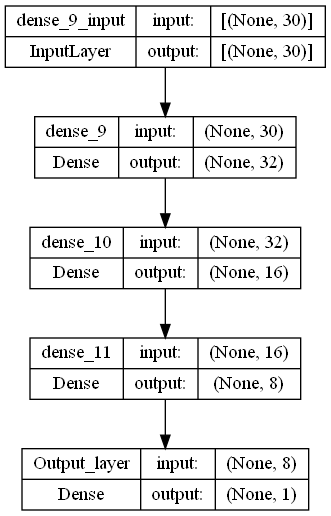

In [86]:
keras.utils.plot_model(model, show_shapes=True, to_file='cancer_model.png')

#### Train(학습)

In [87]:
hist = model.fit(train_dataset, epochs=N_EPOCHS, validation_data=val_dataset)

Epoch 1/150
7/7 [==============================] - 1s 16ms/step - loss: 0.6079 - accuracy: 0.6857 - val_loss: 0.5870 - val_accuracy: 0.8022
Epoch 2/150
7/7 [==============================] - 0s 3ms/step - loss: 0.5478 - accuracy: 0.8257 - val_loss: 0.5405 - val_accuracy: 0.8681
Epoch 3/150
7/7 [==============================] - 0s 4ms/step - loss: 0.4975 - accuracy: 0.9086 - val_loss: 0.4997 - val_accuracy: 0.8791
Epoch 4/150
7/7 [==============================] - 0s 3ms/step - loss: 0.4564 - accuracy: 0.9257 - val_loss: 0.4627 - val_accuracy: 0.8791
Epoch 5/150
7/7 [==============================] - 0s 2ms/step - loss: 0.4156 - accuracy: 0.9429 - val_loss: 0.4251 - val_accuracy: 0.9011
Epoch 6/150
7/7 [==============================] - 0s 2ms/step - loss: 0.3743 - accuracy: 0.9514 - val_loss: 0.3860 - val_accuracy: 0.9011
Epoch 7/150
7/7 [==============================] - 0s 2ms/step - loss: 0.3366 - accuracy: 0.9629 - val_loss: 0.3459 - val_accuracy: 0.9341
Epoch 8/150
7/7 [=========

7/7 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9971 - val_loss: 0.0305 - val_accuracy: 0.9780
Epoch 60/150
7/7 [==============================] - 0s 2ms/step - loss: 0.0189 - accuracy: 0.9971 - val_loss: 0.0307 - val_accuracy: 0.9780
Epoch 61/150
7/7 [==============================] - 0s 2ms/step - loss: 0.0184 - accuracy: 0.9971 - val_loss: 0.0308 - val_accuracy: 0.9780
Epoch 62/150
7/7 [==============================] - 0s 2ms/step - loss: 0.0176 - accuracy: 0.9971 - val_loss: 0.0315 - val_accuracy: 0.9780
Epoch 63/150
7/7 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9971 - val_loss: 0.0314 - val_accuracy: 0.9780
Epoch 64/150
7/7 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9971 - val_loss: 0.0314 - val_accuracy: 0.9780
Epoch 65/150
7/7 [==============================] - 0s 3ms/step - loss: 0.0159 - accuracy: 0.9971 - val_loss: 0.0316 - val_accuracy: 0.9780
Epoch 66/150
7/7 [===============

7/7 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0435 - val_accuracy: 0.9780
Epoch 118/150
7/7 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0437 - val_accuracy: 0.9780
Epoch 119/150
7/7 [==============================] - 0s 3ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0440 - val_accuracy: 0.9780
Epoch 120/150
7/7 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0441 - val_accuracy: 0.9780
Epoch 121/150
7/7 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0445 - val_accuracy: 0.9780
Epoch 122/150
7/7 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0448 - val_accuracy: 0.9780
Epoch 123/150
7/7 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0450 - val_accuracy: 0.9780
Epoch 124/150
7/7 [========

#### 결과 시각화

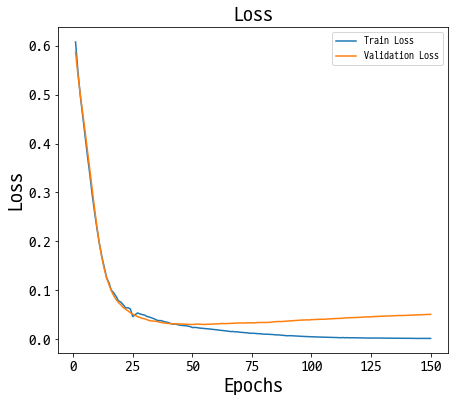

In [88]:
import matplotlib.pyplot as plt

# loss
plt.figure(figsize=(7,6))
plt.plot(range(1, N_EPOCHS+1), hist.history['loss'], label='Train Loss')
plt.plot(range(1, N_EPOCHS+1), hist.history['val_loss'], label='Validation Loss')
plt.title('Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

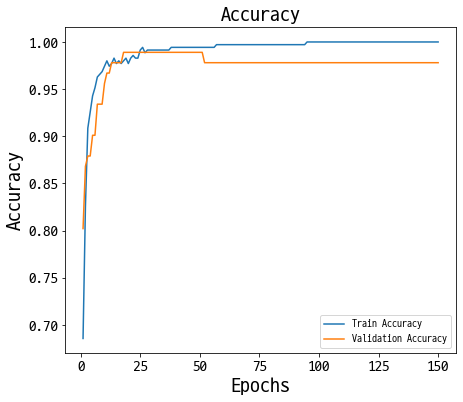

In [89]:
# accuracy
plt.figure(figsize=(7,6))
plt.plot(range(1, N_EPOCHS+1), hist.history['accuracy'], label='Train Accuracy')
plt.plot(range(1, N_EPOCHS+1), hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 최종평가

In [90]:
loss, acc = model.evaluate(test_dataset)

3/3 [==============================] - 0s 2ms/step - loss: 0.1643 - accuracy: 0.9561


In [91]:
print(loss, acc)

0.1642630696296692 0.9561403393745422


#### 모델저장

In [92]:
model.save('models/breast_cancer_model')

INFO:tensorflow:Assets written to: models/breast_cancer_model\assets


#### 새로운 데이터 추론

In [93]:
new_data = X_test[:5]
new_data_scaled = scaler.transform(new_data)

In [94]:
pred = model.predict(new_data_scaled)

1/1 [==============================] - 0s 40ms/step


In [95]:
pred

array([[3.7294086e-08],
       [6.8187397e-36],
       [2.1280302e-09],
       [9.9999595e-01],
       [1.4654393e-10]], dtype=float32)

In [96]:
threshold = 0.5
result = (pred > threshold).astype(np.int8)
result

array([[0],
       [0],
       [0],
       [1],
       [0]], dtype=int8)

In [97]:
result_label = np.where(pred > threshold, "양성-1", "악성-0")
result_label

array([['악성-0'],
       ['악성-0'],
       ['악성-0'],
       ['양성-1'],
       ['악성-0']], dtype='<U4')

- 모델의 분류 예측 결과 후처리 -> 모델이 출력한 확률을 class로 변환
    - 다중 분류(모델이 클래스별 확률 출력) : np.argmax(예측결과, axis=1)
    - 이진 분류(모델이 양성의 확률 출력) : np.where(pred > threshold, '양성 label', '음성 label')

# Tensorflow 2.3이하 버전에서 Train dataset 구성 및 학습 
- 위의 코드들은 2.4 이후 버전
- 2.3 이하버전에서는 
    1. train_dataset 구성 시 repeat()를 추가
    2. 학습 시 train/validation 1 epoch당 step 횟수를 추가
        - steps_per_epoch: train set에 대한 1 epoch 당 step 횟수
        - validation_steps: validationset 에 대한 step 횟수

In [98]:
train_dataset2 = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train)).shuffle(N_TRAIN).batch(N_BATCHS, drop_remainder=True).repeat()

val_dataset2 = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val)).batch(N_BATCHS)
test_dataset2 = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test)).batch(N_BATCHS)

In [99]:
steps_per_epoch = N_TRAIN // N_BATCHS #repeat() 때문에 len()을 사용못함
validation_steps = len(val_dataset2) #len(Dataset): step수 반환
print(steps_per_epoch, validation_steps)

7 2


In [100]:
model = create_wisconsin_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [101]:
model.fit(train_dataset2, 
          steps_per_epoch=steps_per_epoch,
          validation_data=val_dataset2,
          validation_steps=validation_steps, 
          epochs=10)

Epoch 1/10
7/7 [==============================] - 0s 16ms/step - loss: 0.6913 - accuracy: 0.5114 - val_loss: 0.6588 - val_accuracy: 0.6593
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.6412 - accuracy: 0.6971 - val_loss: 0.6087 - val_accuracy: 0.7802
Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.5896 - accuracy: 0.8714 - val_loss: 0.5513 - val_accuracy: 0.8901
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.5298 - accuracy: 0.9400 - val_loss: 0.4857 - val_accuracy: 0.9341
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.4604 - accuracy: 0.9514 - val_loss: 0.4155 - val_accuracy: 0.9560
Epoch 6/10
7/7 [==============================] - 0s 4ms/step - loss: 0.3844 - accuracy: 0.9543 - val_loss: 0.3447 - val_accuracy: 0.9560
Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.3159 - accuracy: 0.9686 - val_loss: 0.2835 - val_accuracy: 0.9560
Epoch 8/10
7/7 [=================